Import Necessary Dependencies

In [1]:
import numpy as np
import pandas as pd
import xlrd as xl
from pandas import ExcelWriter
from pandas import ExcelFile
import pickle, re, json, os, datetime, time

import pprint
pp = pprint.PrettyPrinter(indent=4)

#Read the Data

In [37]:
data = pd.read_excel('../data/all_data.xlsx')
data['Text Content']=data['Text Content'].astype(str)
data['Code']=data['Code'].astype(str)

In [38]:
sz = data['Code'].size
print(f"Size of data (instances) is {sz}")

Size of data (instances) is 8536


Appending Original Data

In [39]:
# Extract features and labels and convert them to vectors/lists
features = data['Text Content'].tolist() 
labels = data['Code'].tolist()

In [42]:
## Only use this functio to remove unwanted rows
def find_locations(my_list, value):
    locations = []
    for i, element in enumerate(my_list):
        if element == value:
            locations.append(i)
    return locations

# Example usage
my_list = labels
search_value = 'nan' ##unwanted row's labels

result = find_locations(my_list, search_value)
print(f"Locations of {search_value} in the list: {result}")


Locations of nan in the list: []


In [43]:
## Get the set of all unique knowledge types in the corpus
import pprint
knowledge_types = list(set(labels))
print("Number of unique knowledge types: "+str(len(knowledge_types)))
knowledge_types.sort()

pp.pprint(knowledge_types)

Number of unique knowledge types: 14
[   'Bug Reproduction',
    'Contribution and Commitment',
    'Expected Behaviour',
    'Future Plan',
    'Investigation and Exploration',
    'Motivation',
    'Observed Bug Behaviour',
    'Potential New Issues and Requests',
    'Solution Discussion',
    'Solution Usage',
    'Task Progress',
    'Testing',
    'Usage',
    'Workarounds']


Logistic Regression

In [9]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split

In [44]:
# Split dataset into training (80%) and test sets (20%)
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.2, random_state=42, shuffle=True)

14.424575278265964


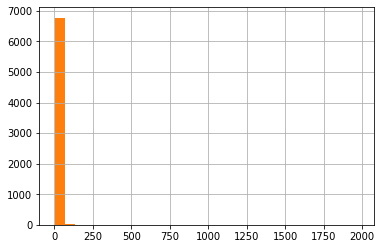

In [45]:
# get length of all the messages in the train set
seq_len = [len(i.split()) for i in X_train]
pd.Series(seq_len).hist(bins = 30)

histogram = pd.Series(seq_len)
histogram.hist(bins=30)
print(histogram.mean())

In [46]:
import numpy as np
import plotly.graph_objects as go

sentences = features

# Calculate the number of words in each sentence
num_words = [len(sentence.split()) for sentence in sentences]

# Calculate mean and standard deviation of the number of words
mean = np.mean(num_words)
std_dev = np.std(num_words)

# Create an array of values for the x-axis
x = np.linspace(mean - 3*std_dev, mean + 3*std_dev, 100)

# Calculate the corresponding y-values using the Gaussian distribution formula
y = (1/(std_dev * np.sqrt(2 * np.pi))) * np.exp(-0.5 * ((x - mean)/std_dev)**2)

# Create the trace for the Gaussian distribution
trace = go.Scatter(x=x, y=y, mode='lines', line=dict(color='blue'), name='Gaussian Distribution')

# Create the layout
layout = go.Layout(
    title='Gaussian Distribution of Number of Words in Sentences',
    xaxis=dict(title='Number of Words'),
    yaxis=dict(title='Probability Density')
)

# Create the figure
fig = go.Figure(data=[trace], layout=layout)

# Show the figure
fig.show()

## Find the peak indices of the y-values
peak_indices = np.where(y == np.max(y))[0]

# Get the corresponding x-values for the peak indices
peak_x_values = x[peak_indices]
# Print the peak x-values
print("Peak x-values:", peak_x_values)

Peak x-values: [12.86626081 15.92099317]


C:\Users\Soihem\AppData\Roaming\Python\Python310\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression

C:\Users\Soihem\AppData\Roaming\Python\Python310\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression

C:

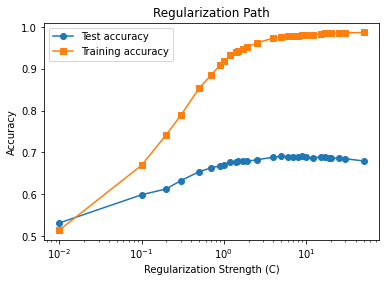

In [50]:
import matplotlib.pyplot as plt
C_values=[0.01, 0.1, 0.2, 0.3, 0.5, 0.7, 0.9, 1, 1.2, 1.4, 1.5, 1.7, 1.9, 2.5, 4, 5, 6, 7, 8, 9, 10, 12, 15, 17, 19, 20, 25, 30, 50]
accuracy_scores=[]
acc2_score=[]
for C in C_values:    
    vectorizer = CountVectorizer()
    X_train_tf = vectorizer.fit_transform(X_train)
    X_test_tf = vectorizer.transform(X_test)

    clf = LogisticRegression(penalty='l2', solver='lbfgs', C=C)
    model = clf.fit(X_train_tf, y_train)
    y_pred = clf.predict(X_test_tf)
    accuracy = model.score(X_test_tf, y_test)
    acc2 = model.score(X_train_tf, y_train)
    accuracy_scores.append(accuracy)
    acc2_score.append(acc2)
    #print(classification_report(y_test, y_pred))
    #print("Accuracy on test set")
    #print(accuracy)
    #print("Accuracy on training")
    #print(acc2)
#print(classification_report(y_test, y_pred))
plt.plot(C_values, accuracy_scores, marker='o', label='Test accuracy')
plt.plot(C_values, acc2_score, marker='s', label='Training accuracy')
plt.xscale('log')
plt.legend()
plt.xlabel('Regularization Strength (C)')
plt.ylabel('Accuracy')
plt.title('Regularization Path')
plt.show()

In [52]:
#Optimal value of C that maximizes Test accuracy
l = list(zip(C_values, accuracy_scores))
# Find the maximum value in the second column
max_value = max(l, key=lambda x: x[1])
print(f"The optimal regularixation parameter is: {max_value[0]}")

The optimal regularixation parameter is: 9


In [53]:
from sklearn.metrics import classification_report

X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.2, random_state=10, shuffle=True)

vectorizer = CountVectorizer()
X_train_tf = vectorizer.fit_transform(X_train)
X_test_tf = vectorizer.transform(X_test)

clf = LogisticRegression(penalty='l2', solver='lbfgs', C=max_value[0])
model = clf.fit(X_train_tf, y_train)
y_pred = clf.predict(X_test_tf)
accuracy = model.score(X_test_tf, y_test)
acc2 = model.score(X_train_tf, y_train)
print(classification_report(y_test, y_pred))
print("Accuracy on test set")
print(accuracy)
print("Accuracy on training")
print(acc2)

                                   precision    recall  f1-score   support

                 Bug Reproduction       0.63      0.62      0.63       148
      Contribution and Commitment       0.84      0.86      0.85       170
               Expected Behaviour       0.35      0.23      0.28        30
                      Future Plan       0.86      0.86      0.86         7
    Investigation and Exploration       0.58      0.53      0.55       167
                       Motivation       0.48      0.48      0.48        71
           Observed Bug Behaviour       0.71      0.50      0.59        90
Potential New Issues and Requests       0.43      0.31      0.36        52
              Solution Discussion       0.73      0.84      0.78       796
                   Solution Usage       0.67      0.50      0.57         4
                    Task Progress       0.54      0.43      0.48        30
                          Testing       0.75      0.50      0.60         6
                        

C:\Users\Soihem\AppData\Roaming\Python\Python310\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



CNN

In [91]:
import numpy as np
import tensorflow
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Conv1D, GlobalMaxPooling1D, Dense, MaxPool1D
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split

In [56]:
# Split dataset into training and validation sets
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.2, random_state=42, shuffle=True)

In [ ]:
# Split dataset into training and test sets
#X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.2, random_state=42, shuffle=True)

# Split training set into training and validation sets
#X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42, shuffle=True)


In [57]:
# Encode labels as integers
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
le.fit(y_train)
y_train = le.transform(y_train)
y_test = le.transform(y_test)

In [58]:
# Convert target variables to one-hot encoding
num_classes = len(knowledge_types)
y_train = to_categorical(y_train, num_classes)
y_test = to_categorical(y_test, num_classes)

In [74]:
# Tokenize and pad sequences
from tensorflow.keras.preprocessing.text import Tokenizer
#max_sequence_length = 1000
max_sequence_length = 30 # because most of the sentences contain 16 words, for faster training
tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(X_train)
X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)
X_train_pad = pad_sequences(X_train_seq, maxlen=max_sequence_length)
X_test_pad = pad_sequences(X_test_seq, maxlen=max_sequence_length)

In [75]:
vocab_size = len(tokenizer.word_index)+1
print("Vocabulary size", vocab_size)

Vocabulary size 10335


In [88]:
# Define the model architecture
from keras.layers import Dense, Dropout, Embedding, Conv1D, GlobalMaxPooling1D
model = Sequential()
model.add(Embedding(input_dim=10335, output_dim=100, input_length=max_sequence_length))
model.add(Conv1D(filters=16, kernel_size=4, activation='relu'))
model.add(GlobalMaxPooling1D())
#model.add(Dense(units=64, activation='relu'))
model.add(Dropout(rate=0.2))
model.add(Dense(units=num_classes, activation='softmax'))

In [89]:
# Compile the model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [84]:
# Train the model
model.fit(X_train_pad, y_train, validation_data=(X_test_pad, y_test), epochs=20, batch_size=32)

Epoch 1/20
214/214 [==============================] - 6s 26ms/step - loss: 2.0563 - accuracy: 0.4047 - val_loss: 1.8227 - val_accuracy: 0.4889
Epoch 2/20
214/214 [==============================] - 4s 21ms/step - loss: 1.7162 - accuracy: 0.5095 - val_loss: 1.6439 - val_accuracy: 0.5316
Epoch 3/20
214/214 [==============================] - 5s 24ms/step - loss: 1.4852 - accuracy: 0.5631 - val_loss: 1.5192 - val_accuracy: 0.5539
Epoch 4/20
214/214 [==============================] - 6s 26ms/step - loss: 1.2851 - accuracy: 0.6153 - val_loss: 1.4447 - val_accuracy: 0.5738
Epoch 5/20
214/214 [==============================] - 5s 25ms/step - loss: 1.1109 - accuracy: 0.6626 - val_loss: 1.3978 - val_accuracy: 0.5937
Epoch 6/20
214/214 [==============================] - 6s 27ms/step - loss: 0.9801 - accuracy: 0.6976 - val_loss: 1.3662 - val_accuracy: 0.6083
Epoch 7/20
214/214 [==============================] - 5s 26ms/step - loss: 0.8650 - accuracy: 0.7310 - val_loss: 1.3507 - val_accuracy: 0.6095

In [ ]:
#Validation Split method
#model.fit(X_train_pad, y_train, validation_split=0.1, epochs=10, batch_size=32)

In [ ]:
#Evaluation for validation split
#model.evaluate(X_test_pad, y_test, batch_size=1)

Visualize your final result in Tensorboard (When you find the best hyperparameters after running the above model, run another model for tensorboard)

In [98]:
# Define the model architecture
from keras.layers import Dense, Dropout, Embedding, Conv1D, GlobalMaxPooling1D
model = Sequential()
model.add(Embedding(input_dim=10335, output_dim=30, input_length=max_sequence_length))
model.add(Conv1D(filters=16, kernel_size=3, activation='relu'))
model.add(GlobalMaxPooling1D())
#model.add(Dense(units=64, activation='relu'))
model.add(Dropout(rate=0.2))
model.add(Dense(units=num_classes, activation='softmax'))

In [99]:
# Compile the model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [100]:
%load_ext tensorboard

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [101]:
import os
root_logdir = os.path.join(os.curdir, "my_logs3")

In [102]:
def get_run_logdir():
    import time
    run_id = time.strftime("run_%Y_%m_%d-%H_%M_%S")
    return os.path.join(root_logdir, run_id)
run_logdir = get_run_logdir()

In [103]:
## To visualize CNN in tensorboard (Optional)
tensorboard_cb = keras.callbacks.TensorBoard(run_logdir)
history = model.fit(X_train_pad, y_train, validation_data=(X_test_pad, y_test), epochs=30, batch_size=32,callbacks=[tensorboard_cb])

Epoch 1/30
214/214 [==============================] - 2s 8ms/step - loss: 2.1352 - accuracy: 0.4329 - val_loss: 1.9094 - val_accuracy: 0.4508
Epoch 2/30
214/214 [==============================] - 1s 6ms/step - loss: 1.8098 - accuracy: 0.4892 - val_loss: 1.7469 - val_accuracy: 0.5082
Epoch 3/30
214/214 [==============================] - 1s 6ms/step - loss: 1.6165 - accuracy: 0.5340 - val_loss: 1.6305 - val_accuracy: 0.5345
Epoch 4/30
214/214 [==============================] - 1s 7ms/step - loss: 1.4549 - accuracy: 0.5704 - val_loss: 1.5544 - val_accuracy: 0.5544
Epoch 5/30
214/214 [==============================] - 1s 6ms/step - loss: 1.3220 - accuracy: 0.6076 - val_loss: 1.5137 - val_accuracy: 0.5609
Epoch 6/30
214/214 [==============================] - 1s 5ms/step - loss: 1.2295 - accuracy: 0.6336 - val_loss: 1.4818 - val_accuracy: 0.5697
Epoch 7/30
214/214 [==============================] - 2s 8ms/step - loss: 1.1363 - accuracy: 0.6583 - val_loss: 1.4715 - val_accuracy: 0.5785
Epoch 

In [104]:
%load_ext tensorboard
%tensorboard --logdir=./my_logs3 --port=6006